In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 考察

- 正解ラベルが少ない分パラメータ・センシティブであり、適切なnuを見つけるのに苦心した。
- 実問題では視覚的に学習がうまく行っているかを確かめる以外の指標がないと、この手法を直接適用してパラメータサーチを行うのは少し骨が折れると感じた。

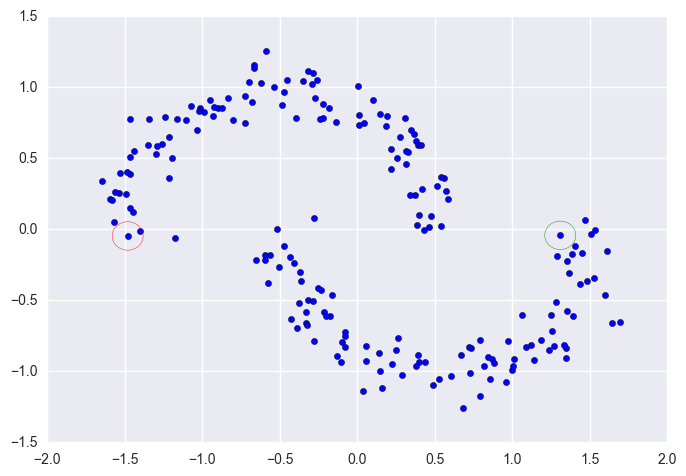

In [11]:
n = 200
a = np.linspace(0, np.pi, n/2)
u = np.concatenate([np.cos(a) - 0.5, np.cos(a) + 0.5]) + np.random.randn(n)/10
v = np.concatenate([np.sin(a), -np.sin(a)]) + np.random.randn(n)/10

X = np.dstack([u, v])[0]
y = [-1, 1]
label_idx = [n/2-1, n/2]
labeled_X = X[label_idx]

fig, ax = plt.subplots()
ax.scatter(u, v)
ax.add_patch(plt.Circle(labeled_X[0], 0.1, color = 'r', fill = False))
ax.add_patch(plt.Circle(labeled_X[1], 0.1, color = 'g', fill = False))

In [15]:
class SemiSupervisedClassifier(object):
    def __init__(self, l2 = 1, nu = 1, h = 0.1):
        self.l2 = l2
        self.nu = nu
        self.h = h
        
    def _gaussian_kernel(self, x1, x2, h, axis = None):
        if axis is not None:
            return np.sum(np.exp(-(x1 - x2) ** 2 / (2 * (h ** 2))), axis = axis)
        else:
            return np.exp(-(x1 - x2) ** 2 / (2 * (h ** 2)))
    
    def _neighbor_graph(self, X):
        n = X.size if X.ndim == 1 else X.shape[0]
        axis = None if X.ndim == 1 else 1
        h = self.h
        phi = np.ones((n, n))
        for i in range(n):
            phi[i] = self._gaussian_kernel(X, X[i], h, axis)
        self.phi = phi
        return phi
        
    def fit(self, X, y, label_idx):
        self.X = X
        self.y = y
        self.label_idx = label_idx
        size_l = len(label_idx)
        size_all = X.size if X.ndim == 1 else X.shape[0]
        phi = self._neighbor_graph(X)
        phi_tilde = phi[label_idx]
        D = np.diag(np.sum(phi, axis = 1))
        L = D - phi
        self.L = L
        tmp = phi_tilde.transpose().dot(phi_tilde) + self.l2 * np.eye(size_all) + 2 * self.nu * phi.transpose().dot(L).dot(phi)
        tmp_inv = np.linalg.pinv(tmp)
        weights = tmp_inv.dot(np.dot(phi_tilde.transpose(), y))
        self.weights = weights
        return self
            
    def predict(self, X):
        n = self.weights.size
        test_length = X.size if X.ndim == 1 else X.shape[0]
        predict_val = np.zeros((test_length,))
        #Xが多次元である場合はサンプルごとの距離を一次元に集約するためaxis=1で和をとる
        axis = None if self.X.ndim == 1 else 1
        for i in range(n):
            predict_val += self.weights[i] * self._gaussian_kernel(X, self.X[i], self.h, axis = axis)
        return predict_val

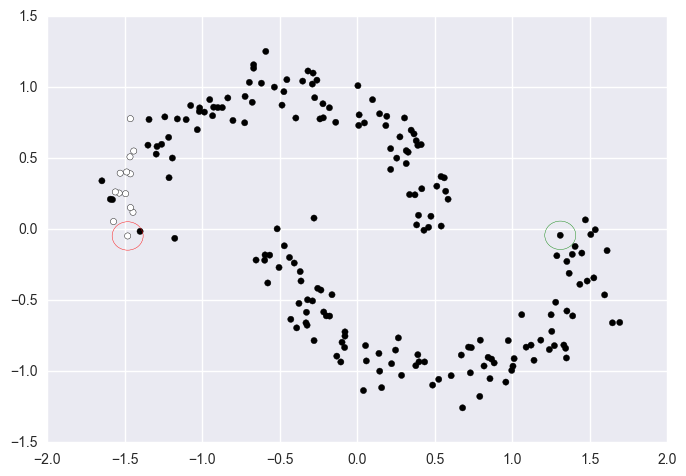

In [17]:
clf = SemiSupervisedClassifier().fit(X, y, label_idx)

pred = (clf.predict(X) > 0)*2 -1

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c= pred)
ax.add_patch(plt.Circle(labeled_X[0], 0.1, color = 'r', fill = False))
ax.add_patch(plt.Circle(labeled_X[1], 0.1, color = 'g', fill = False))

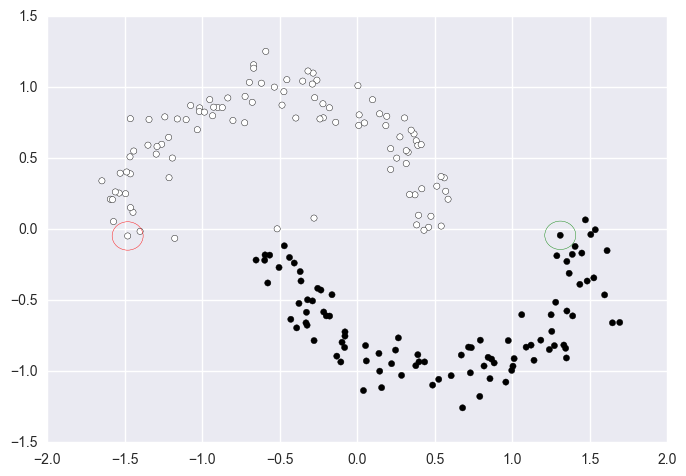

In [50]:
#various parameters
nu = 5e-7
l2 = 1
h = 0.1

clf = SemiSupervisedClassifier(l2, nu, h).fit(X, y, label_idx)

pred = (clf.predict(X) > 0)*2 -1

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c= pred)
ax.add_patch(plt.Circle(labeled_X[0], 0.1, color = 'r', fill = False))
ax.add_patch(plt.Circle(labeled_X[1], 0.1, color = 'g', fill = False))